In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import seaborn as sns
from LabUtils.Utils import mkdirifnotexists

In [2]:
from LabData.DataAnalyses.TenK_Trajectories.biological_age.predict_age import work_dir, pred_dir, \
        modality_name_mapping, add_text_at_corner, pred_residuals_fig_dir
#     work_dir, pred_dir, , load_ranked_residuals, Ys_dir, sm, r2_score, \
#     BodyMeasuresLoader, add_text_at_corner


In [3]:
fig_dir = mkdirifnotexists(os.path.join(work_dir, 'figures', 'figure6'))

In [23]:
disease_name_dic = {'Diabetes mellitus, type unspecified': 'Diabetes mellitus',
                    'haemolytic anaemia due to G6PD deficiency': 'Haemolytic anaemia',
                    'Anxiety or fear-related disorders': 'Anxiety',
                    'Anaemias or other erythrocyte disorders': 'Anaemia',
                    'Non-alcoholic fatty liver disease': 'NAFLD',
                    'Fracture of unspecified body region': 'Fracture',
                    'Ulcer of stomach or duodenum': 'Peptic ulcer'
                   }


rank_or_z = 'centered' # 'zscore'

def load_dfs():
    df_male = pd.read_csv(os.path.join(pred_residuals_fig_dir, 'medical_conditions_corrs', 
                                       'logit_df_male_equal_%s.csv' % rank_or_z), index_col=0).replace(0, np.nan)\
                        .rename(columns=disease_name_dic)
    df_female = pd.read_csv(os.path.join(pred_residuals_fig_dir, 'medical_conditions_corrs', 
                                       'logit_df_female_equal_%s.csv' % rank_or_z), index_col=0).replace(0, np.nan)\
                        .rename(columns=disease_name_dic)
    df_male.columns = [c.strip() for c in df_male.columns]
    df_female.columns = [c.strip() for c in df_female.columns]
    return df_male, df_female

def load_dfs_full():
    df_male = pd.read_csv(os.path.join(pred_residuals_fig_dir, 'medical_conditions_corrs', 
                                       'logit_df_male_equal_%s_full.csv' % rank_or_z), index_col=0).replace(0, np.nan)\
                        .rename(columns=disease_name_dic)
    df_female = pd.read_csv(os.path.join(pred_residuals_fig_dir, 'medical_conditions_corrs', 
                                       'logit_df_female_equal_%s_full.csv' % rank_or_z), index_col=0).replace(0, np.nan)\
                        .rename(columns=disease_name_dic)
    df_male.columns = [c.strip() for c in df_male.columns]
    df_female.columns = [c.strip() for c in df_female.columns]
    return df_male, df_female


In [5]:
def plot_heatmap(ax, df, sex, vmin, vmax, xticklabels=[], colorbar_cax=None):
    mask = df.isnull()
    sns.heatmap(df, ax=ax, mask=mask, center=1., cmap='RdBu', xticklabels=True, cbar=False, 
                vmin=vmin, vmax=vmax, linewidths=0.5, linecolor='lightgrey', clip_on=False)

#     clb = fig.colorbar(ax.get_children()[0], orientation="vertical", aspect=20)
#     clb.ax.set_ylabel('Odds Ratio', fontsize=15)
    # ax.tick_params(labelsize=15)
    ax.set_xticklabels(xticklabels, rotation=45, ha='right')
#     ax.set_title(sex, fontsize=15)
    ax.set_ylabel(sex, fontsize=15)
    ax.tick_params(labelsize=15, left=False, bottom=False)
    
    if colorbar_cax:
        clb = plt.colorbar(ax.get_children()[0], orientation="vertical", aspect=20, cax=colorbar_cax)
        clb.ax.set_ylabel('Odds Ratio', fontsize=15)
        clb.ax.tick_params(labelsize=15)
        ax.tick_params(labelsize=15, left=False, bottom=True)
        

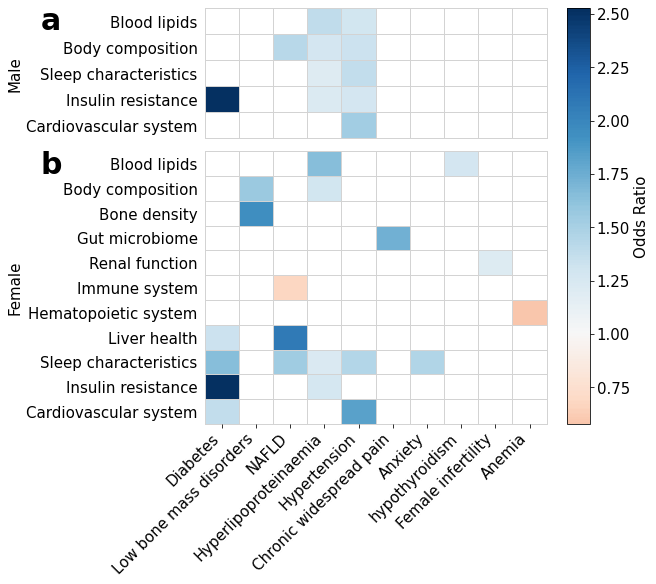

In [186]:
ax_dict = plt.figure(constrained_layout=True, figsize=(9, 8)).subplot_mosaic(
    """
    AAAAAAAAAAAAAAAC
    BBBBBBBBBBBBBBBC
    BBBBBBBBBBBBBBBC
    """,
    gridspec_kw={"wspace": 0.5, "hspace": 0},
)



df_male, df_female = load_dfs()


vmin = min(df_male.min().min(), df_female.min().min())
vmax = min(df_male.max().max(), df_female.max().max())
plot_heatmap(ax_dict['A'], 
             df_male.reindex(df_female.index).reindex(df_female.columns, axis=1).dropna(how='all'),
            'Male', vmin=vmin, vmax=vmax)
plot_heatmap(ax_dict['B'], 
             df_female,
            'Female', vmin=vmin, vmax=vmax, xticklabels=df_female.columns, colorbar_cax=ax_dict['C'])

ax_dict['A'].text(-0.45, 0.9, 'a', ha='center', va='center', transform=ax_dict['A'].transAxes, fontsize=30, weight='bold')
ax_dict['B'].text(-0.45, 0.95, 'b', ha='center', va='center', transform=ax_dict['B'].transAxes, fontsize=30, weight='bold')

plt.savefig(os.path.join(fig_dir, 'figure6.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure6.pdf'), dpi=300, bbox_inches='tight')

# V2

In [7]:
def interchange_dfs(df1, df2, separate_by_empty=False):
    merged_cols = df1.columns.tolist() + [c for c in df2.columns if c not in df1.columns]
    merged_idx = df1.index.tolist() + [c for c in df2.index if c not in df1.index]
    d1_t = df1.reindex(merged_idx, axis=0).reindex(merged_cols, axis=1)
    d2_t = df2.reindex(merged_idx, axis=0).reindex(merged_cols, axis=1)
    if separate_by_empty:
        d3 = pd.concat([pd.concat((d1_t[[c]], d2_t[[c]], pd.DataFrame(columns=[''])), axis=1) for c in merged_cols], axis=1)
    else:
        d3 = pd.concat([pd.concat((d1_t[[c]], d2_t[[c]]), axis=1) for c in merged_cols], axis=1)
    return d3
    

def plot_interchange_heatmap(df_merged, ax, label1='F', label2='M'):
    sns.heatmap(df_merged.astype(float), mask=df_merged.isnull(), 
            linecolor='white', cbar=False, ax=ax, linewidths=0.5, 
                center=1., cmap='PRGn') # linewidths=0.5
    M = df_merged.shape[1]
    for i in range(0, M + 1, 2):
        ax.axvline(i, color='white', lw=10, clip_on=False)
        if i > 0:
            ax.axvline(i-0.2, color='lightgrey', lw=1, clip_on=False)
        if i < M:
            ax.axvline(i+0.2, color='lightgrey', lw=1, clip_on=False)
            ax.text(i+1-0.4, -0.1, label1, ha='center', fontsize=15)
            ax.text(i+1+0.4, -0.1, label2, ha='center', fontsize=15)
    ax.set_xticks(range(1, M+1, 2))
    ax.set_xticklabels([df_merged.columns[i] for i in range(0, df_merged.shape[1], 2)])
    ax.tick_params(labelsize=15, left=True, bottom=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    clb = plt.colorbar(ax.get_children()[0], orientation="vertical", aspect=20, pad=0.01)#, ticks=np.arange(-0.5, 3, 0.5))
    clb.ax.set_ylabel('Odds Ratio', fontsize=15)
    clb.ax.tick_params(labelsize=15)
    ax.tick_params(labelsize=15, left=False, bottom=True)

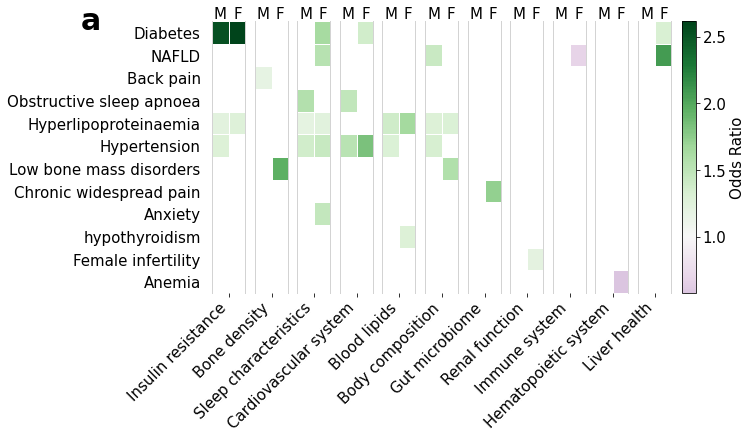

In [201]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

df_male, df_female = load_dfs()
df_merged = interchange_dfs(df_male.T, df_female.T, False)

plot_interchange_heatmap(df_merged=df_merged, ax=ax, label1='M', label2='F')
ax.text(-0.25, 1, 'a', ha='center', va='center', transform=ax.transAxes, fontsize=30, weight='bold')

plt.savefig(os.path.join(fig_dir, 'figure6_v2.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure6_v2.pdf'), dpi=300, bbox_inches='tight')

Text(-0.25, 1, 'a')

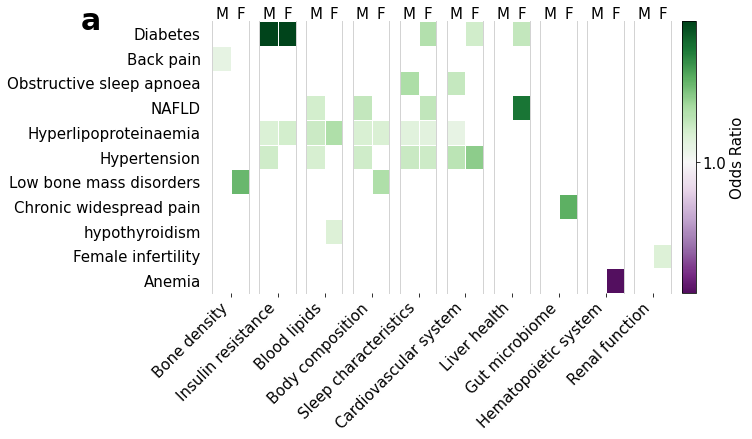

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

df_male, df_female = load_dfs()
df_merged = interchange_dfs(df_male.T, df_female.T, False)

plot_interchange_heatmap(df_merged=df_merged, ax=ax, label1='M', label2='F')
ax.text(-0.25, 1, 'a', ha='center', va='center', transform=ax.transAxes, fontsize=30, weight='bold')

# plt.savefig(os.path.join(fig_dir, 'figure6_v2.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(fig_dir, 'figure6_v2.pdf'), dpi=300, bbox_inches='tight')

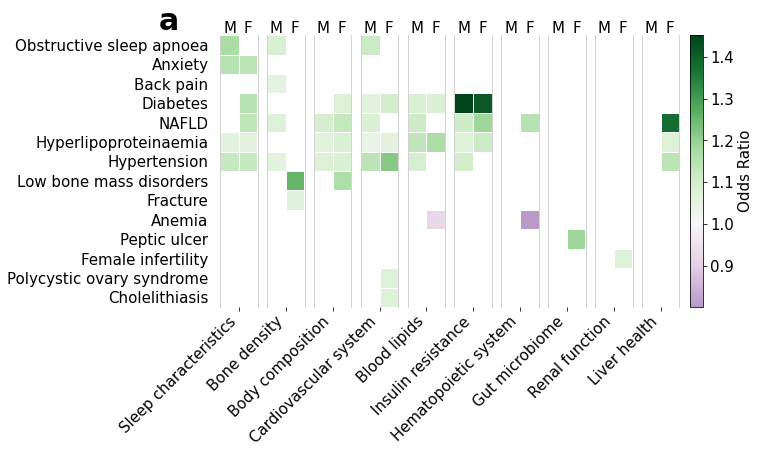

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

df_male, df_female = load_dfs()
df_merged = interchange_dfs(df_male.T, df_female.T, False)

plot_interchange_heatmap(df_merged=df_merged, ax=ax, label1='M', label2='F')
ax.text(-0.1, 1.05, 'a', ha='center', va='center', transform=ax.transAxes, fontsize=30, weight='bold')

plt.savefig(os.path.join(fig_dir, 'figure6_v2.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure6_v2.pdf'), dpi=300, bbox_inches='tight')

In [22]:
(df_merged.iloc[:, range(0, df_merged.shape[1], 2)]>0).sum().sum()

24

In [20]:
(df_merged>0).sum().sum()

54

In [24]:
df_male_full, df_female_full = load_dfs_full()

In [28]:
pd.concat((df_male_full, df_female_full)).dropna(how='all', axis=1).shape

(28, 49)

In [30]:
print(df_male_full.notnull().sum().sum())
print(df_female_full.notnull().sum().sum())
# pd.concat((df_male_full, df_female_full)).dropna(how='all', axis=1).notnull().sum().sum()

551
557
